In [16]:
import numpy as np
import scipy.io.wavfile as wav
import librosa
import matplotlib.pyplot as plt
from scipy.signal import hann
from numpy.fft import fft, ifft

In [17]:
def calc_istft(X, win, N_STFT, R_STFT, sides):
    _, L, M = X.shape
    if sides == 'onesided':
        X = np.concatenate((X, np.conj(X[-2:0:-1, :, :])), axis=0)
    x_frames = ifft(X, axis=0).real

    # Apply synthesis window
    win = np.tile(win[:, np.newaxis, np.newaxis], (1, L, M))
    x_frames = x_frames * win
    x_frames = x_frames[:N_STFT, :, :]

    # Init output
    x = np.zeros((R_STFT * (L - 1) + N_STFT, M))

    # OLA processing
    for l in range(L):
        sampIdx = slice(l * R_STFT, l * R_STFT + N_STFT)
        x[sampIdx, :] += x_frames[:, l, :]

    return x

def calc_stft(x, fs, win, N_STFT, R_STFT, sides):
    N_STFT_half = N_STFT // 2 + 1

    # Get frequency vector
    f = np.linspace(0, fs / 2, N_STFT_half)
    if sides == 'twosided':
        f = np.concatenate((f, -f[-2:0:-1]))

    # Init
    L = (len(x) - N_STFT + R_STFT) // R_STFT
    M = x.shape[1]
    X = np.zeros((N_STFT_half if sides == 'onesided' else N_STFT, L, M), dtype=complex)

    for m in range(M):
        for l in range(L):
            x_frame = x[l * R_STFT:l * R_STFT + N_STFT, m]
            X_frame = fft(win * x_frame)
            if sides == 'onesided':
                X[:, l, m] = X_frame[:N_STFT_half]
            else:
                X[:, l, m] = X_frame

    return X, f

def plot_spec(spec, magPowLin, xTickProp, yTickProp, cRange, plotColorbar):
    if magPowLin == 'mag':
        plt.imshow(20 * np.log10(np.abs(spec)), aspect='auto', vmin=cRange[0], vmax=cRange[1])
    elif magPowLin == 'pow':
        plt.imshow(10 * np.log10(np.abs(spec)), aspect='auto', vmin=cRange[0], vmax=cRange[1])
    elif magPowLin == 'lin':
        plt.imshow(spec, aspect='auto', vmin=cRange[0], vmax=cRange[1])
    else:
        raise ValueError('Undefined scaling option.')

    plt.gca().invert_yaxis()
    plt.gca().tick_params(length=0)

    if plotColorbar:
        plt.colorbar()

    if xTickProp:
        xStartValue, xRes, xTickDist = xTickProp
        if xTickDist != 0:
            xTicks = np.arange(0, spec.shape[1], xTickDist)
            xTickLabels = (xStartValue + xTicks * xRes).astype(int).astype(str)
            plt.xticks(xTicks, xTickLabels)
        else:
            plt.xticks([])
    else:
        plt.xticks([])

    if yTickProp:
        yStartValue, yRes, ytickDist = yTickProp
        if ytickDist != 0:
            yTicks = np.arange(0, spec.shape[0], ytickDist)
            yTickLabels = (yStartValue + yTicks * yRes).astype(int).astype(str)
            plt.yticks(yTicks, yTickLabels)
        else:
            plt.yticks([])
    else:
        plt.yticks([])

In [3]:
# Define constants and initialize variables
N_STFT = 2048
r = 0.057
c = 343.3
m_pos = np.array([[r, 0, 0], [r/2, -np.sqrt(3)/2 * r, 0], [-r/2, -np.sqrt(3)/2 * r, 0], [-r, 0, 0], [-r/2, np.sqrt(3)/2 * r, 0], [r/2, np.sqrt(3)/2 * r, 0]]).T
azimuth_deg = 0
elevation_deg = -90
azimuth = np.deg2rad(azimuth_deg)
elevation = np.deg2rad(elevation_deg)
s_pos = 50 * r * np.array([np.cos(elevation) * np.cos(azimuth), np.cos(elevation) * np.sin(azimuth), np.sin(elevation)])

step = 5
angles = np.arange(0, 360, step)
num_angles = len(angles)
ir_data = [None] * num_angles
fft_data = [None] * num_angles

num_polar_freq = N_STFT // 2 + 1
polars = np.zeros((num_polar_freq, num_angles, 6))

monName = ["monCQGLL74L", "monG7SMCCBW", "monKD8N255G", "monGHHX", "mon99PJ"]
for channel in range(6):
    for k in range(5):
        for i in range(num_angles):
            filename = f"AnechoicRoomMeasurements/IRs_Channel_{channel + 1}_Hann/IR_{monName[k]}_{angles[i]}_Channel_{channel + 1}.wav"
            fs, ir_data[i] = wav.read(filename)
            N = len(ir_data[i])
            N_FFT = 2**int(np.ceil(np.log2(N)))
            fft_data[i] = fft(ir_data[i], N_FFT)
            Z = fft_data[i]
            magnitude = np.abs(Z)
            index_deg = (i + int(270 / step)) % int(360 / step)
            index_freq = np.linspace(0, N_FFT // 2, num_polar_freq).astype(int)
            polars[:, index_deg, channel] += magnitude[index_freq]

polars /= 5
polars = 20 * np.log10(polars)
maxMag = np.max(polars)
polars -= maxMag

np.savez("NpzData/polars.npz", polars=polars, elevation_deg=elevation_deg, step=step, c=c, m_pos=m_pos, s_pos=s_pos, fs=fs)
print("Job done")

Job done


/tmp/ipykernel_19683/720347963.py:13: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = np.sqrt(hann(N_STFT))


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

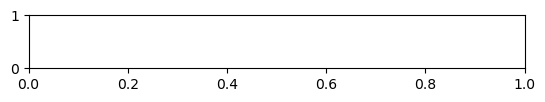

<Figure size 1000x600 with 0 Axes>

In [18]:
# Load the polars data and perform beamforming
data = np.load("NpzData/polars.npz")
polars = data['polars']
elevation_deg = data['elevation_deg']
step = data['step']
c = data['c']
m_pos = data['m_pos']
s_pos = data['s_pos']
fs = data['fs']

N_STFT = 2048
R_STFT = N_STFT // 2
win = np.sqrt(hann(N_STFT))

compen_width_deg = 40
compen_index = np.mod(np.arange(elevation_deg - compen_width_deg / 2, elevation_deg + compen_width_deg / 2 + step, step) + 360, 360) / step
A_compen = -np.mean(polars[:, compen_index.astype(int), :], axis=1)

# Adjust the shape of A_compen to match the shape of polars
n_low_freq_bins = int(200 * N_STFT / fs)
A_compen[:n_low_freq_bins, :] = 1
A_compen = 10**(A_compen / 20)

# Input data time domain
for setNr in range(1, 3):
    totalFileNr = 18 if setNr == 1 else 8
    for fileNr in range(1, totalFileNr + 1):
        input_t, fs_input = librosa.load(f"Temporary/toBeTested/set{setNr}_Recording ({fileNr}).flac", sr=None, mono=False)
        input_t = input_t.T  # Ensure the shape is (samples, channels)
        input_stft, _ = calc_stft(input_t, fs_input, win, N_STFT, R_STFT, 'onesided')
        xTickProp = [0, R_STFT / fs_input, 0]
        yTickProp = [0, fs_input / (2000 * R_STFT), R_STFT // 2]
        cRange = [-45, 15]

        fig_in = plt.figure()
        iterations = input_stft.shape[2]
        for i in range(iterations):
            plt.subplot(iterations, 1, i + 1)
            plot_spec(input_stft[:, :, i], 'mag', xTickProp, yTickProp, cRange, 0)
            plt.ylabel('Freq (kHz)')
        plt.xlabel("Time")
        plt.show()

        # Initialize the output
        output_stft = np.zeros((input_stft.shape[0], input_stft.shape[1], 1), dtype=complex)

        # Pipeline
        n_freq_bins = input_stft.shape[0]

        # Calculate coefficients then apply
        for i in range(n_freq_bins):
            dasb_delay = np.dot(s_pos, m_pos) / np.linalg.norm(s_pos) / c
            d_dasb = np.exp(-1j * 2 * np.pi * (fs_input / N_STFT * i) * dasb_delay) / m_pos.shape[1]
            w_dasb = d_dasb.T
            w_dasb /= m_pos.shape[1]
            output_stft[i, :, 0] = np.dot(input_stft[i, :, :], w_dasb)

        fig_out = plt.figure()
        plot_spec(output_stft[:, :, 0], 'mag', xTickProp, yTickProp, cRange, 0)
        plt.ylabel('Freq (kHz)')
        plt.xlabel("Time")
        plt.show()

        output_t = calc_istft(output_stft, win, N_STFT, R_STFT, 'onesided')
        # sf.write(f"Temporary/toBeTested/out_DS/set{setNr}_Recording ({fileNr}).flac", output_t, fs_input)

        # fig_in.savefig(f"Temporary/figures/set{setNr}_Recording ({fileNr}).pdf")
        # fig_out.savefig(f"Temporary/figures/out_DS/set{setNr}_Recording ({fileNr}).pdf")
        print("Job done!")
